### Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
import random

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots

from sklearn import svm
from keras import backend as K
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

import warnings
import os
import sys

seed = 33
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)
tf.compat.v1.set_random_seed(seed)

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Data Exploration and Preparation

### Data Exploration

<code>Insert data exploration here</code>

### Preprocessing

##### Functions definitions

- Defining <code>add_sp_gold</code> to:

    - retrieve ${\text{S\&P 500}}$ stock market index from yfinance;
    - create feature <code>SP_GOLD</code> by computing ${\text{S\&P 500}}/{\text{XAU BGNL}}$;
    - append it to the dataframe.
<br>
<br>
- Defining <code>compute_returns</code> to transform not-index and not-label data into weekly returns.

- Defining <code>train_val_split</code> function to split the original dataset into training and validation sets according to <code>train_fraction</code>, which is set to $0.8$ by default.

- Defining <code>scaler</code> to scale the data. Default is $\text{Stadard}$ scaling, otherwise $\text{MinMax}$ scaling can be applied.

In [2]:
def add_sp_gold(df):

    # defining starting (first row) and ending (last row) dates to download data from yfinance
    start_date = str(df['Data'][0])[:10]
    end_date = str(df['Data'][df.shape[0]-1])[:10]

    # downloading 'close' data from yfinance 
    sp500 = yf.download('^GSPC', start=start_date, end=end_date, interval='1wk')
    sp500 = sp500['Close']

    # defining the new feature SP500/GOLD and renaming the column
    sp500_gold = pd.DataFrame(sp500.to_numpy() / df['XAU BGNL'].to_numpy())
    sp500_gold.columns = ['SP_GOLD']

    # concatenating the new feature to the original dataframe
    df = pd.concat([df, sp500_gold], axis=1)

    return df



def compute_returns(df):

    # these are the features which have to be transformed
    returns_labels = ['Cl1', 'MXCN', 'MXEU', 'MXJP', 'MXRU', 'MXUS', 'VIX', 'GT10']
    returns_features = df[returns_labels].to_numpy()

    # calculating the returns as the differences between feature at time t and time t-1, divided by feature at time t-1 (times 100)
    returns = pd.DataFrame(np.diff(returns_features, axis=0) / returns_features[:-1, :]) * 100

    # restoring the original column names and indexes
    returns.columns = returns_labels
    returns.index = df.index[1:]
    
    # defining the new dataset as concatenation of the new, transformed features and the untouched ones
    df_new = pd.concat([returns, df[['SP_GOLD', 'ECSURPUS', 'Y']].iloc[1:]], axis=1)

    return df_new



def train_val_split(df, train_fraction = 0.8):

    split_index = int(df.shape[0]*train_fraction)
    train_df = df.iloc[:split_index]
    val_df = df.iloc[split_index:]

    return train_df, val_df



def scaler(t_df, v_df, scaling='Standard'):
    
    # defining new dataframe copies to work with in order to not modify the original ones
    train_df = t_df.copy()
    val_df = v_df.copy()
    
    columns = list(train_df.columns)
    columns.remove('Y')

    # if 'minmax' scaling is specified when calling the function, minmax scaling is applied to the data
    if scaling.upper() == 'MINMAX':
        for c in columns:
            min = np.min(train_df[c])
            max = np.max(train_df[c])
            train_df[c] = (train_df[c]-min)/(max-min)
            # to scale the data contained in the validation set we still use the minimum and the maximum
            # of the data in the training set, since we should not exploit the knowledge of validation set data
            val_df[c] = (val_df[c]-min)/(max-min)
        print('MinMax scaling was applied')

    # if nothing or something different from 'minmax' is specified, standard scaling is applied 
    else: 
        for c in columns:
            mean = np.mean(train_df[c])
            std = np.std(train_df[c])
            train_df[c] = (train_df[c]-mean)/(std)
            val_df[c] = (val_df[c]-mean)/(std)
        print('Standard scaling was applied')

        if scaling.upper() != 'STANDARD':
            print('Inserted option was not available')
    
    return train_df, val_df

##### Preprocessing

In [3]:
# reading dataframe from excel file
df = pd.read_excel('FinancialMarketData.xlsx', 'EWS')

# adding sp_gold column to dataframe
df_sp_gold = add_sp_gold(df)

# cutting out unnecessary features
reduced_df = df_sp_gold[['Cl1', 'MXCN', 'MXEU', 'MXJP', 'MXRU', 'MXUS', 'VIX', 'GT10', 'ECSURPUS', 'SP_GOLD', 'Y']]

# computing returns for non-index, non_label features
returns_df = compute_returns(reduced_df)

# splitting the dataframe into training and validation sets
train_df, val_df = train_val_split(returns_df)

# normalize the data
train_df_norm, val_df_norm = scaler(train_df, val_df)

[*********************100%***********************]  1 of 1 completed
Standard scaling was applied


In [4]:
# separating input data from labels
x_train = train_df_norm.drop(labels = 'Y', axis = 1)
x_val = val_df_norm.drop(labels = 'Y', axis = 1)
y_train = train_df_norm['Y']
y_val = val_df_norm['Y']

# Anomaly Detection

### Random Forest

##### Optimizing RF parameters

In [5]:
# specifying parameter values to try out
max_depth_list = [6, 8, 10, 12]
n_estimators_list = [100, 150, 200]
min_samples_split_list = [6, 8, 10]

# initializing the 'best recall' value
recall = 0

# looping through each of the parameters to optimize and running random forest algorithm for each combination of the parameters.
# if the recall metric obtained through cross-validation is higher than the current best recall, then the parameters values are stored
for max_depth in max_depth_list:
  for n_estimators in n_estimators_list:
    for min_samples_split in min_samples_split_list:

      rand_forest = RandomForestClassifier(n_estimators = n_estimators,
                                           min_samples_split = min_samples_split,
                                           criterion = 'entropy',
                                           random_state = seed,
                                           max_depth = max_depth)
      rand_forest.fit(x_train, y_train)
      y_pred = cross_val_predict(rand_forest, x_train, y_train, cv = 10)

      if(recall_score(y_train, y_pred) > recall):
        best_max_depth = max_depth
        best_n_estimators = n_estimators
        best_min_samples_split = min_samples_split
        recall = recall_score(y_train, y_pred)


print(f'Best max_depth:\t\t{best_max_depth}')
print(f'Best n_estimators:\t{best_n_estimators}')
print(f'Best min_samples_split:\t{best_min_samples_split}')
print(f'Recall:\t\t{recall:.3f}')

Best max_depth:		12
Best n_estimators:	150
Best min_samples_split:	8
Recall:		0.399


##### Computing predictions with optimal RF parameters

In [6]:
# values found from optimization above
# best_n_estimators = 100
# best_min_samples_split = 10
# best_max_depth = 12

In [7]:
# Computing predictions with optimal RF parameters
rand_forest = RandomForestClassifier(n_estimators = best_n_estimators,
                                     min_samples_split = best_min_samples_split,
                                     criterion = 'entropy',
                                     random_state = seed,
                                     max_depth = best_max_depth)
rand_forest.fit(x_train, y_train)
y_pred = rand_forest.predict(x_val)

In [8]:
# computing the confusion matrix and defining the values that will be contained in the confusion matrix plot
cf_matrix = (confusion_matrix(y_val, y_pred, labels=[0, 1], sample_weight=None) / len(y_pred) * 100)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v3}' for v1, v3 in zip(group_names, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# printing the metrics
print(f'Accuracy:\t{accuracy_score(y_val, y_pred):.3f}')
print(f'Recall:\t\t{recall_score(y_val, y_pred):.3f}')
print(f'Precision:\t{precision_score(y_val, y_pred):.3f}')
print(f'F1score:\t{f1_score(y_val, y_pred):.3f}')
for var, val in zip(group_names, group_percentages):
  print(f'{var}:\t{val}')

Accuracy:	0.883
Recall:		0.207
Precision:	0.667
F1score:	0.316
True Neg:	85.59%
False Pos:	1.35%
False Neg:	10.36%
True Pos:	2.70%


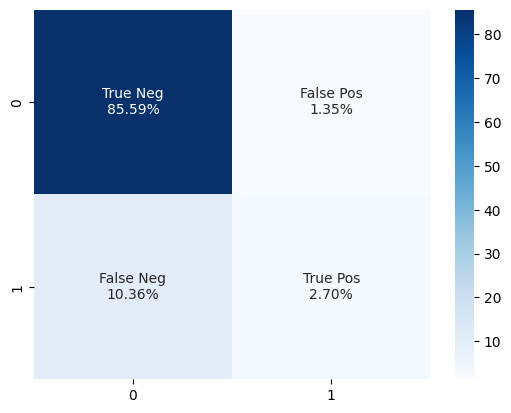

In [9]:
# printing the confusion matrix
_ = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

### Support Vector Machines

##### Optimizing anomalies weight

In [10]:
# initializing the 'best recall' value
best_recall = 0

# specifying possible values of the weights for the anomalies class
min_w = 1
max_w = 5
step_w = 0.5

# similarly to the RF case:
# looping through the possible weight values and running SVM algorithm for each combination of the parameters.
# if the recall metric obtained through cross-validation is higher than the current best recall, then the optimal weight value is stored
for w in np.arange(min_w, max_w, step_w):
    svm_linear = svm.SVC(kernel='linear', class_weight={0:1, 1:w}, random_state=seed)
    svm_linear.fit(x_train, y_train)
    y_pred_linear = cross_val_predict(svm_linear, x_train, y_train, cv = 10)
    recall = recall_score(y_train, y_pred_linear)
    if recall > best_recall:
        best_recall = recall
        linear_w = w

print(f'Linear Kernel recall: {best_recall}')
print(f'Linear Kernel weight: {linear_w:.1f}')

# repeating the same procedure described above, but using the 'radial basis function' kernel instead of the 'linear' kernel
best_recall = 0

for w in np.arange(min_w, max_w, step_w):
    svm_rbf = svm.SVC(kernel='rbf', class_weight={0:1, 1:w}, random_state=seed)
    svm_rbf.fit(x_train, y_train)
    y_pred_rbf = cross_val_predict(svm_rbf, x_train, y_train, cv = 10)
    recall = recall_score(y_train, y_pred_rbf)
    if recall > best_recall:
        best_recall = recall
        rbf_w = w

print(f'Radial Basis Funciton Kernel recall: {best_recall}')
print(f'Radial Basis Function Kernel weight: {rbf_w:.1f}')

Linear Kernel recall: 0.6634615384615384
Linear Kernel weight: 4.5
Radial Basis Funciton Kernel recall: 0.6682692307692307
Radial Basis Function Kernel weight: 4.0


##### Using SVMs with linear and radial basis function kernels

In [11]:
# values found from optimization above
# linear_w = 4.5
# rbf_w = 4.0

In [12]:
# computing predictions using the best weights for both the radial basis function and linear kernels
svm_linear = svm.SVC(kernel='linear', class_weight={0:1, 1:linear_w}, random_state=seed)
svm_linear.fit(x_train, y_train)
y_pred_linear = svm_linear.predict(x_val)

svm_rbf = svm.SVC(kernel='rbf', class_weight={0:1, 1:rbf_w}, random_state=seed)
svm_rbf.fit(x_train, y_train)
y_pred_rbf = svm_rbf.predict(x_val)

In [13]:
# similarly to the RF case:
# computing the confusion matrices for the two kernels and defining the values that will be contained in the confusion matrix plots
title = ['Linear Kernel', 'Radial Basis Function Kernel']

for y_pred, i in zip([y_pred_linear, y_pred_rbf], [0, 1]):

    cf_matrix = (confusion_matrix(y_val, y_pred, labels=[1, 0], sample_weight=None) / len(y_pred) * 100)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v3}' for v1, v3 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    print(f'{title[i]} metrics:')
    print(f'Accuracy:\t{accuracy_score(y_val, y_pred):.3f}')
    print(f'Recall:\t\t{recall_score(y_val, y_pred):.3f}')
    print(f'Precision:\t{precision_score(y_val, y_pred):.3f}')
    print(f'F1score:\t{f1_score(y_val, y_pred):.3f}')
    for var, val in zip(group_names, group_percentages):
        print(f'{var}:\t{val}')
    if i==0: print('\n')

Linear Kernel metrics:
Accuracy:	0.455
Recall:		0.483
Precision:	0.117
F1score:	0.188
True Neg:	6.31%
False Pos:	6.76%
False Neg:	47.75%
True Pos:	39.19%


Radial Basis Function Kernel metrics:
Accuracy:	0.869
Recall:		0.483
Precision:	0.500
F1score:	0.491
True Neg:	6.31%
False Pos:	6.76%
False Neg:	6.31%
True Pos:	80.63%


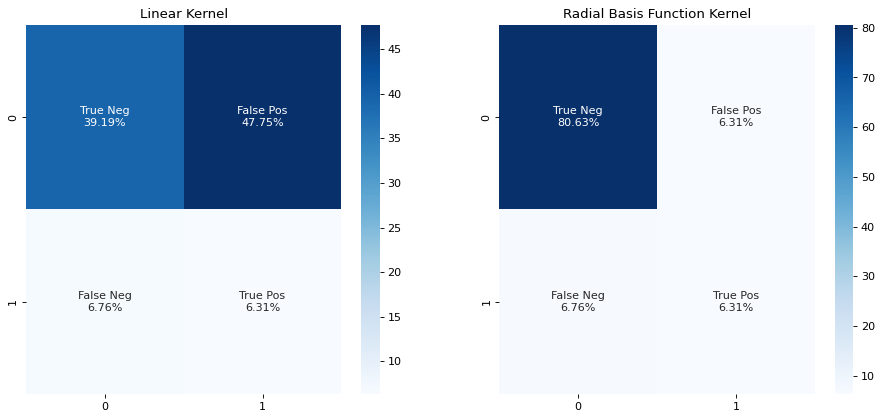

In [14]:
# plotting the two confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14,6), dpi=80)

for y_pred, i in zip([y_pred_linear, y_pred_rbf], [0, 1]):

    cf_matrix = (confusion_matrix(y_val, y_pred, labels=[0, 1], sample_weight=None) / len(y_pred) * 100)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v3}' for v1, v3 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    _ = sns.heatmap(cf_matrix, annot=labels, fmt='', ax=axes[i], cmap='Blues')
    axes[i].set_title(title[i])

### LSTM

##### Function definition

- Defining <code>WINDOW</code> constant equal to $50$. This is the dimension of the window, which determines how much the network is able to look backward in order to correctly classify the last timestamp of the time series.

- Defining <code>build_samples</code> to prepare data in order to feed it to the LSTM network. Data is divided into windows (which are <code>WINDOW</code> timestamps long) and reshaped into a <code>(samples, WINDOW, features)</code> dimensional tensor. 

- Defining <code>recall</code> metric in order to be able to use it during network training.

In [6]:
WINDOW = 50



def build_samples(x, y, W=50):

  samples = x.shape[0]
  features = x.shape[1]

  # defining the shape of the output data tensor
  x_new = np.empty((samples-W+1, W, features))

  # inserting the windows into the new data vector through looping and indexing
  for i in range(x_new.shape[0]):
    x_new[i] = x[i:i+W]

  # reshaping also the labels (the first W-1 labels are discarded)
  y_new = y[W-1:].reshape(y[W-1:].shape[0])

  return x_new, y_new



def recall(y_true, y_pred):

  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall



def f1score(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_score = 2*((precision*recall)/(precision+recall+K.epsilon()))
    return f1_score

##### Data reshaping and model compiling

Since we do not want to lose <code>WINDOW-1</code> validation samples due to how <code>build_samples</code> function is designed, we use the last part of the training instances to build the <em>'windowed'</em> validation set. This can be done because the samples are not shuffled and the validation set samples are exactly subsequent to the training set ones.

In [22]:
# creating training instances using build_samples function
x_train_window, y_train_window = build_samples(x_train.to_numpy(), y_train.to_numpy(), WINDOW)

# creating validation instances using build_samples function
x_val_window, y_val_window = build_samples(np.append(x_train[1-WINDOW:], x_val, axis=0),
                                           np.append(y_train[1-WINDOW:], y_val, axis=0),
                                           WINDOW)

In [23]:
def build_LSTM(input_shape):

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    LSTM1 = tfkl.LSTM(units=8, activation='relu', return_sequences=True, name='LSTM1')(input_layer)
    LSTM2 = tfkl.LSTM(units=4, activation='relu', return_sequences=False, name='LSTM2')(LSTM1)
    # dropout1 = tfkl.Dropout(0.3, name='dropout1')(LSTM2)
    dense = tfkl.Dense(units=32, activation='relu', name='classifier')(LSTM2)
    # dropout2 = tfkl.Dropout(0.3, name='dropout2')(dense)
    output_layer = tfkl.Dense(units=1, activation='sigmoid', name='output')(dense)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.legacy.Adam(), metrics=[recall, f1score])

    return model

In [24]:
input_shape = x_train_window.shape[1:]
model = build_LSTM(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 50, 10)]          0         
                                                                 
 LSTM1 (LSTM)                (None, 50, 8)             608       
                                                                 
 LSTM2 (LSTM)                (None, 4)                 208       
                                                                 
 classifier (Dense)          (None, 32)                160       
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 1009 (3.94 KB)
Trainable params: 1009 (3.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### Model training

In [25]:
epochs = 100
batch_size = 32

callbacks = [tfk.callbacks.EarlyStopping(monitor='f1score', mode='max', patience=10, restore_best_weights=True)]
x_train_window, y_train_window = shuffle(x_train_window, y_train_window, random_state = seed)
x_val_window, y_val_window = shuffle(x_val_window, y_val_window, random_state = seed)

history = model.fit(
    x = x_train_window,
    y = y_train_window,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = (x_val_window, y_val_window),
    callbacks = callbacks,
    class_weight = {0:1, 1:5}  
).history

Epoch 1/100
27/27 [==============================] - 1s 15ms/step - loss: 1.2884 - recall: 1.0000 - f1score: 0.3718 - val_loss: 0.7409 - val_recall: 1.0000 - val_f1score: 0.2267
Epoch 2/100
27/27 [==============================] - 0s 9ms/step - loss: 1.2298 - recall: 1.0000 - f1score: 0.3608 - val_loss: 0.7814 - val_recall: 1.0000 - val_f1score: 0.2267
Epoch 3/100
27/27 [==============================] - 0s 10ms/step - loss: 1.1612 - recall: 1.0000 - f1score: 0.3608 - val_loss: 0.7703 - val_recall: 1.0000 - val_f1score: 0.2267
Epoch 4/100
27/27 [==============================] - 0s 9ms/step - loss: 1.0612 - recall: 1.0000 - f1score: 0.3631 - val_loss: 0.7754 - val_recall: 1.0000 - val_f1score: 0.2600
Epoch 5/100
27/27 [==============================] - 0s 9ms/step - loss: 0.9517 - recall: 0.9630 - f1score: 0.3948 - val_loss: 0.7450 - val_recall: 0.9238 - val_f1score: 0.3400
Epoch 6/100
27/27 [==============================] - 0s 9ms/step - loss: 0.8945 - recall: 0.9511 - f1score: 0.548

##### Evaluating optimal threshold to maximize F1

In [26]:
y_val_pred = model.predict(x_val_window)

start = 0.2
stop = 0.8
step = 0.05
f1 = 0
best_threshold = 0.5
y_val_temp = np.copy(y_val_pred)

for threshold in np.arange(start, stop+step, step):

    y_val_temp[y_val_pred>=threshold]=1
    y_val_temp[y_val_pred<threshold]=0

    if f1_score(y_val_window, y_val_temp)>f1:
        f1 = f1_score(y_val_window, y_val_temp)
        best_threshold = threshold

print(f'Best threshold: {best_threshold:.2f}')
y_val_pred[y_val_pred>=best_threshold]=1
y_val_pred[y_val_pred<best_threshold]=0

7/7 [==============================] - 0s 2ms/step
Best threshold: 0.80


##### Results

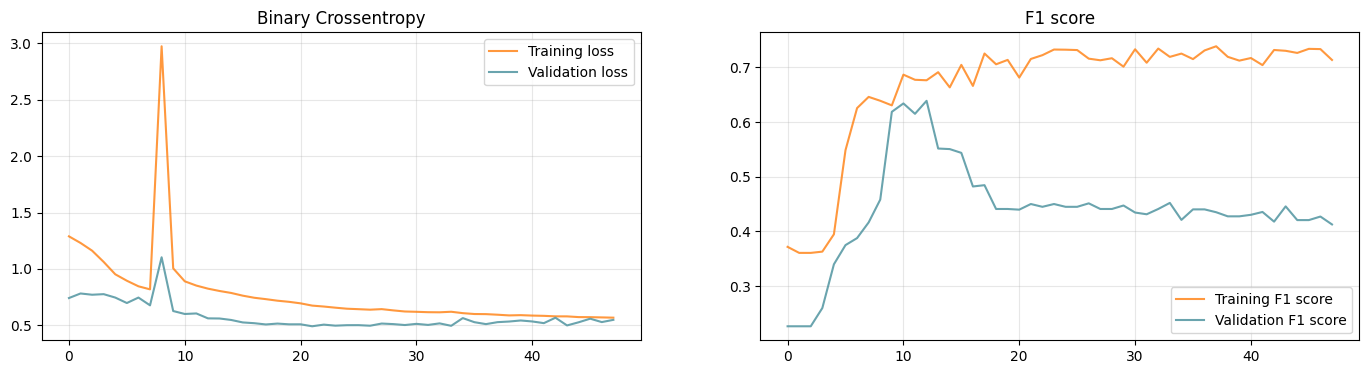

In [27]:
best_epoch = np.argmax(history['val_recall'])
fig, axes = plt.subplots(1, 2, figsize=(17,4))

axes[0].plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
axes[0].plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
axes[0].set_title('Binary Crossentropy')
axes[0].legend()
axes[0].grid(alpha=.3)

axes[1].plot(history['f1score'], label='Training F1 score', alpha=.8, color='#ff7f0e')
axes[1].plot(history['val_f1score'], label='Validation F1 score', alpha=.9, color='#5a9aa5')
axes[1].set_title('F1 score')
axes[1].legend()
axes[1].grid(alpha=.3)

In [28]:
cf_matrix = (confusion_matrix(y_val_window, y_val_pred, labels=[0, 1], sample_weight=None) / len(y_val_window) * 100)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v3}' for v1, v3 in zip(group_names, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

print(f'Accuracy:\t{accuracy_score(y_val_window, y_val_pred):.3f}')
print(f'Recall:\t\t{recall_score(y_val_window, y_val_pred):.3f}')
print(f'Precision:\t{precision_score(y_val_window, y_val_pred):.3f}')
print(f'F1score:\t{f1_score(y_val_window, y_val_pred):.3f}')
for var, val in zip(group_names, group_percentages):
  print(f'{var}:\t{val}')

Accuracy:	0.892
Recall:		0.448
Precision:	0.619
F1score:	0.520
True Neg:	83.33%
False Pos:	3.60%
False Neg:	7.21%
True Pos:	5.86%


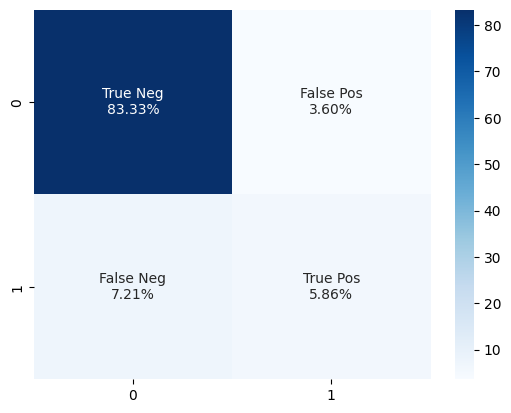

In [29]:
_ = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [30]:
original_stdout = sys.stdout

with open('log.txt', 'a') as log_file:
    sys.stdout = log_file
    model.summary()
    print(f'Accuracy:\t{accuracy_score(y_val_window, y_val_pred):.3f}')
    print(f'Recall:\t\t{recall_score(y_val_window, y_val_pred):.3f}')
    print(f'Precision:\t{precision_score(y_val_window, y_val_pred):.3f}')
    print(f'F1score:\t{f1_score(y_val_window, y_val_pred):.3f}')
    for var, val in zip(group_names, group_percentages):
        print(f'{var}:\t{val}')
    print('\n\n\n')
    sys.stdout = original_stdout

### Transformer

### Autoencoder (fully connected)

### Autoencoder (convolutional)

### Copulas

### Final model: Ensamble Averaging

# Portfolio